In [1]:
import csv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

from constants.constants import *
from PIL import Image
from enum import Enum

# Embeds graphs in Jupyter notebook (instead of pop-ups)
%matplotlib inline

pd.set_option('display.max_columns', None) # show all columns
pd.set_option('display.max_rows', None) # show all rows

In [2]:
# Use values aggregated by games; more games would lead to higher numbers but not necessarily better quality performances
teams_agg_df = pd.read_csv('./data/exploratory_analysis/eda_same_season.csv')

In [3]:
def get_correlation(df, columns):
    '''Returns correlation between selected columns'''
    df_corr = df[columns].corr().abs() # get correlation matrix; absolute values for strength of correlation
    df_corr = df_corr.where(np.triu(np.ones(df_corr.shape)).astype(bool)) # get upper triangular values only
    df_corr = df_corr.stack().sort_values(ascending=False).reset_index()
    df_corr.columns = ['col_1', 'col_2', 'corr']
    return df_corr[df_corr['corr'] < 1].reset_index(drop=True)

def get_indiv_correlation(df, col_1, col_2, print_corr=True):
    corr_df = df.select_dtypes(include=[np.number]).corr()[col_1].reset_index()
    corr = corr_df[corr_df['index'] == col_2][col_1].iloc[0]
    if print_corr:
        print(
            f"{'No strong' if abs(corr) < 0.7 else 'Strong'} correlation between {col_1}",
            f"and {col_2} (corr = {corr:.2f})"
        )
    return corr

def in_different_category(col1, col2):
    for col in TEAM_COLUMNS_DICT_COMBINED.values():
        if col1 in col and col2 in col:
            return False
    return True

def get_outliers(df, col, show_info=True, sort_ascending=False):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers_df = df[
        (df[col] < Q1-1.5*IQR) |
        (df[col] > Q3+1.5*IQR)
    ].sort_values(by=col, ascending=sort_ascending).reset_index(drop=True)
    if show_info:
        if len(outliers_df) > 0:
            print("\nOutliers:")
            display(outliers_df)
        print("\nOverview:")
        display(df.describe())
    return outliers_df

def get_upper_deviation(df, col):
    return round(df[df[col] >= df[col].quantile(0.99)][col].mean(), 2)

def get_lower_deviation(df, col):
    return round(df[df[col] <= df[col].quantile(0.01)][col].mean(), 2)

def plot_regression_line(df, x_col, y_col):
    x_data = df[x_col].to_numpy()
    y_data = df[y_col].to_numpy()
    m, b = np.polyfit(x_data, y_data, 1)
    plt.plot(x_data, m*x_data+b, color='red')

In [4]:
# For getting icons when plotting graphs
class IconType(Enum):
    CLUB = "club_icons"
    COUNTRY = "country_icons"

#     "Cache" icons once processed
ICON_CACHE = { IconType.CLUB.name: {}, IconType.COUNTRY.name: {}, }
CLUB_ICON_MAPPING = dict(zip(SQUAD_NAME_MAPPING["final"], SQUAD_NAME_MAPPING["transfermarkt"]))
CLUB_ICON_MAPPING.update({"Empoli": "FC Empoli"})

def get_icon(type_: IconType, icon_name: str, scale: float = 0.1) -> Image:
    icon = ICON_CACHE[type_.name].get(icon_name)
    if icon:
        return icon
#     Find image
    img = Image.open(f"./data/{type_.value}/{icon_name}.png")
#     Resize
    ICON_CACHE[type_.name][f"{icon_name}_{scale}"] = img.resize((int(img.width*scale), int(img.height*scale)))
    return ICON_CACHE[type_.name][f"{icon_name}_{scale}"]

def get_country_icon(country_name: str, scale: float = 0.02) -> Image:
    return get_icon(type_=IconType.COUNTRY, icon_name=country_name, scale=scale)

def get_club_icon(squad_name: str, scale: float = 0.1) -> Image:
#     Note: need to map name in dataframe to saved name (as images taken from transfermarkt)
    return get_icon(type_=IconType.CLUB, icon_name=CLUB_ICON_MAPPING[squad_name], scale=scale)

#     Set custom markers for all clubs
def set_club_markers(df, x_col, y_col, squad_col="squad"):
    for _, row in df.iterrows():
        plt.gca().add_artist(AnnotationBbox(
            OffsetImage(get_club_icon(row[squad_col])),
            (row[x_col], row[y_col]),
            frameon=False, pad=0)
        )

In [5]:
class GROUPBY_TYPE(Enum):
    CLUB = "squad"
    COUNTRY = "country"

def plot_grouped_line_graph(type_: GROUPBY_TYPE, col, agg_func=np.mean, transform_col_func=None):
    """Plot a line graph that tracks a change in a variable over the seasons, grouping by country"""
    year_cols = [type_.value, "season_start_year"]
    df = teams_agg_df[[*year_cols, col]].groupby(year_cols).agg(agg_func).reset_index()

#     For xticks and club icon markings
    start_years = list(df["season_start_year"].unique())
    
    if transform_col_func:
        df[col] = transform_col_func(df[col])

    plt.figure(figsize=(8, 6))
    
    if type_ == GROUPBY_TYPE.COUNTRY:
        for group in list(df[type_.value].unique()):
            # Plot line for each country
            filtered_df = df[df[type_.value] == group]
            plt.plot(filtered_df["season_start_year"], filtered_df[col], label=group)

            #     Add icon
            for i in range(len(filtered_df)):
                plt.gca().add_artist(AnnotationBbox(
                    OffsetImage(get_country_icon(group, scale=0.03)),
                    (filtered_df["season_start_year"].iloc[-1], filtered_df[col].iloc[-1]),
                    frameon=False,
                    pad=0
                ))
    elif type_ == GROUPBY_TYPE.CLUB:
        added_icons = []
#         Get number of seasons in dataset for each club
        df_count = df.groupby(type_.value)[type_.value].count()
#         Get total number of seasons in dataset
        num_seasons = len(df["season_start_year"].unique())
#         Get clubs that appear in every season
        df = df[df.apply(
            lambda row: df_count[df_count.index == row[type_.value]].iloc[0] >= num_seasons,
            axis=1
        )].sort_values(by=col).reset_index(drop=True)
        for quantile in np.arange(0, 1.1, 0.25):
            # Plot line for each quantile if not exists
            quantile_value = df[df["season_start_year"] == start_years[-1]][col].quantile(quantile)
            squad_to_add = df.at[(df[col] == quantile_value).idxmax(), type_.value]
            if not squad_to_add in added_icons:
                added_icons.append(squad_to_add)

#                 Filter by club and sort by year before plotting
                filtered_df = df[df[type_.value] == squad_to_add].sort_values(by="season_start_year")
                plt.plot(filtered_df["season_start_year"], filtered_df[col], label=squad_to_add)
                
#                 Add icon
                for i in range(len(filtered_df)):
                    plt.gca().add_artist(AnnotationBbox(
                        OffsetImage(get_club_icon(squad_to_add)),
                        (filtered_df["season_start_year"].iloc[i], filtered_df[col].iloc[i]),
                        frameon=False,
                        pad=0
                    ))                        

    # Set graph labels
    plt.legend(
        title="Legend",
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0
    )
    plt.gca().set_xticks(start_years)
    plt.gca().set_xticklabels(labels=[f"{x}-{x+1-2000}" for x in start_years])
    plt.grid(True)
    
def plot_country_line_graph(col, agg_func=np.mean, transform_col_func=None):
    plot_grouped_line_graph(type_=GROUPBY_TYPE.COUNTRY, col=col, agg_func=agg_func, transform_col_func=transform_col_func)

def plot_club_line_graph(col, agg_func=np.mean, transform_col_func=None):
    """Plots line graph for club at each quartile (based on last season's values)"""
    plot_grouped_line_graph(type_=GROUPBY_TYPE.CLUB, col=col, agg_func=agg_func, transform_col_func=transform_col_func)

### Win Determinants
#### Correlation with points per game (PPG)
<br>
<u>How PPG works</u>
<ul>
    <li>Win = 3 pts; draw = 1 pt; lose = 0 pts</li>
    <li>PPG = # points in a season / # games in a season</li>
    <li>In this section, we sum PPG from each season played from 2018-2023, and divide it by the number of seasons</li>
    <li>We will use PPG as a representation of "win rate" (higher PPG is an indicator better sporting performance)</li>
</ul>
<u>Why PPG?</u>
<ol>
    <li>Because data is from domestic leagues, which use the point system to rank teams at the end of the season. Teams are given prize money, qualification into continental competition, etc. based on their league standings, which is why using points is the most meaningful metric of success (as opposed to win rate, for example).</li>
    <li>PPG takes draws into account, making comparison easier.</li>
    <li>Last of all, points are averaged on a per-game basis as different leagues may play a different number of games (teams usually play each other twice, once at home and once away, each league may have a different number of teams).</li>
</ol>

#### Examining Correlations and Selecting Determinants (Feature Selection)
<i>Note: "=" here is a shorthand for "suggests that" or "indicate"; correlation is not causation. Possible (but not definite) hypothesis are made to explain potential causal factors behind the trends.</i>
From the table below:
- Strong positive correlation corr >= 0.7
    - <u><i>Goals</i>: the definition of winning is to outscore your opponent (and a goal usually comes from an assist)</u>
        - gd_per90&emsp;&emsp;            0.949770
        - goals_for_per90&emsp;&emsp;     0.843440
        - goals_per90&emsp;&emsp;         0.839428
        - goals_assists_per90&emsp;&emsp; 0.833911
        - assists_per90&emsp;&emsp;       0.806265
        - <u><i>Penalties</i>: more penalties = more goals = more wins</u>
            - goals_assists_per90&emsp;&emsp; 0.833911
            - goals_assists_pens_per90                 0.821052
            - goals_pens_per90&emsp;&emsp;    0.820949
            - goals_pens_per90&emsp;&emsp;    0.820949
        - <u><i>Goal-scoring</i>: more chances = more goals = more wins (note: penalties have around 0.75xG, which is considered very high)</u>
            - gca_per90&emsp;&emsp;           0.838372
            - xg_per90&emsp;&emsp;            0.812467
            - xg_xg_assist_per90&emsp;&emsp;  0.809177
            - npxg_xg_assist_per90&emsp;&emsp;0.793058
            - npxg_per90&emsp;&emsp;          0.789869
            - xg_assist_per90&emsp;&emsp;     0.789843
            - shots_on_target_per90&emsp;&emsp;  0.774389
            - sca_per90&emsp;&emsp;           0.736193
            - assisted_shots_per90&emsp;&emsp;0.730868
            - pass_xa_per90&emsp;&emsp;       0.723043
            - shots_per90&emsp;&emsp;         0.709136
            - <u><i>Field tilt</i>: getting nearer the opponent's goal = better quality chances</u>
                - passes_into_final_third_per90&emsp;&emsp;0.780436
                - touches_att_pen_area_per90&emsp;&emsp;0.774190
                - touches_att_3rd_per90&emsp;&emsp;  0.768357
                - passes_into_penalty_area_per90&emsp;&emsp;0.763788
                - progressive_passes_per90&emsp;&emsp;0.759548
                - carries_into_penalty_area_per90&emsp;&emsp;0.704944
    - <u><i>Possession</i>: More posession generally means more control (the opponent usually will not score if you have the ball). Possession is the amount of time spent on the ball, but possession != attack (e.g. passing the ball around the back). (Note: a team can be considered to have possession when the ball is out of play if they last touched the ball) The actual possession stat may have a lower correlation as teams can hold the ball without passing or are unable to get the ball into dangerous areas to attack the opponent. We will choose the "possession" column over pass volume despite its slightly lower correlation value, as teams can spend longer building up without passing as frequently, and it is a clearer indicator of a manager's tactical approach to the game.</u>
        - gca_passes_live_per90&emsp;&emsp;  0.825139
        - passes_live_per90&emsp;&emsp;   0.770202
        - passes_live_per90&emsp;&emsp;   0.770202
        - touches_per90&emsp;&emsp;       0.757638
        - touches_live_ball_per90&emsp;&emsp;0.757463
        - passes_total_distance_per90&emsp;&emsp; 0.753216
        - possession&emsp;&emsp;          0.748007
        - sca_passes_live_per90&emsp;&emsp;  0.749995
        - touches_mid_3rd_per90&emsp;&emsp;  0.735881
        - carries_per90&emsp;&emsp;       0.711977
    - <u><i>Squad value</i>: more valuable players = better players = more likely to outplay opponents; a more well-rounded squad seems to be better than having a few better players (because rotation due to fatigue/injury, team is only as strong as its weak link?)</u>
        - squad_value_avg&emsp;&emsp;     0.768828
        - squad_value&emsp;&emsp;         0.756773
    - <u><i>Home advantage</i>: At first glance, the popular belief of "home field advantage" (e.g. more home fans, more familiar grounds, better pitch and facilities for home sides) seems to be undermined; playing away from home seems to be better overall, if only slightly, than playing at home. However, on closer inspection, scoring goals at home seem to be more "valuable" i.e. harder to achieve than away, which could be due to teams playing more defensively precisely because they lack home advantage.</u>
        - points_away_per90&emsp;&emsp;   0.877431
        - points_home_per90&emsp;&emsp;   0.863041
        - goals_for_home_per90&emsp;&emsp;0.770918
        - goals_for_away_per90&emsp;&emsp;0.753251
- Weak positive correlation corr < 0.7
    - <u><i>Chance quantity > quality</i>: could it be that creating more chances (see point on Goal-scoring) is more important than converting them?</u>
        - goals_per_shot_on_target                 0.527539
        - goals_per_shot&emsp;&emsp;      0.606186
        - shots_on_target_pct&emsp;&emsp; 0.482586
    - <u><i>Pass accuracy != attacking quality</i>: safe passes are more likely to connect than more difficult but effective ones (not that it does not hurt to reach the target)</u>
        - passes_pct_long&emsp;&emsp;     0.679511
        - passes_pct&emsp;&emsp;          0.670175
        - passes_pct_medium&emsp;&emsp;   0.606499
        - passes_pct_short&emsp;&emsp;    0.600138
    - <u><i>Buying players</i>: as we are looking at the top 5 leagues, the extensive youth development/academy programs +  high pay at the highest level (financial incentive to join) + minimum number of homegrown players in each team (clubs are more willing to pay higher wages to natives/citizens due to the smaller supply) = top talent from each country is likely to be cultivated and stay in their home countries i.e. low brain drain</u>
    - <u><i>Attacking style</i>: crosses and dribbles are falling out of favour</u>
        - foreigners&emsp;&emsp;          0.204583
        - sca_take_ons_per90&emsp;&emsp;  0.511559
        - gca_take_ons_per90&emsp;&emsp;  0.501199
        - take_ons_per90&emsp;&emsp;      0.369559
        - take_ons_won_pct&emsp;&emsp;    0.151999
        - crosses_per90&emsp;&emsp;       0.095730
- Weak negative correlation corr > -0.7
    - <u><i>Defence volume</i>: defending more may not mean you concede fewer high quality chances or even fewer chances overall; having more defensive actions per game may actually your team is getting attacked more often and therefore on the back foot and more likely to concede (and even lose)</u>
        - clearances_per90&emsp;&emsp;   -0.642397
        - aerials_lost_per90&emsp;&emsp; -0.526721
        - tackles_def_3rd_per90&emsp;&emsp; -0.457455
        - blocks_per90&emsp;&emsp;       -0.311611
        - interceptions_per90&emsp;&emsp;-0.280406
    - <u><i>Rotation</i>: Using more players does not lose (or win) games. Although the negative correlation suggests that keeping your better players out of the starting eleven reduces chances of winning, the difference in quality between starters and squad players may not be as significant as many think.</u>
        - players_used&emsp;&emsp;       -0.243510
- Strong positive correlation corr <= -0.7
    - <u><i>Defence</i>: Interestingly, there is a weaker correlation between defence and PPG than attack. A theory is that scoring first changes the game state, forcing opponents to commit forwards in search of a goal and therefore leaving themselves more vulnerable to counter-attacks, which in turn creates more goals and a greater chance of winning.</u>
        - goals_against_per90&emsp;&emsp;-0.744669
        - gk_goals_against_per90&emsp;&emsp;-0.745066

In [6]:
# Select numeric columns for correlation
# Only non-numeric columns are squad and country
# teams_agg_df.select_dtypes(exclude=[np.number]).columns
numeric_df = teams_agg_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
corr_matrix['points_per90'].sort_values()

gk_goals_against_per90                  -0.744828
goals_against_per90                     -0.744207
gk_psxg                                 -0.683992
goals_against_away_per90                -0.671442
clearances_per90                        -0.642076
gk_shots_on_target_against_per90        -0.638149
gk_pct_passes_launched                  -0.557936
goals_against_home_per90                -0.555810
aerials_lost_per90                      -0.526927
gk_goal_kick_length_avg                 -0.475933
passes_dead_per90                       -0.465634
tackles_def_3rd_per90                   -0.457458
blocked_shots_per90                     -0.406163
average_shot_distance                   -0.367752
aerials_won_per90                       -0.348493
gk_corner_kick_goals_against_per90      -0.321631
blocks_per90                            -0.311893
fouls_per90                             -0.305559
take_ons_tackled_pct                    -0.305262
throw_ins_per90                         -0.292573


#### Selected Features
Criteria: significance (correlation), uniqueness, relevance
- Goals scored (goals_per90: 0.839428)
- Goals conceded (gk_goals_against_per90: -0.745066)
- Squad value (squad_value: 0.756773)
- Possession (possession: 0.748007)
<br>
We will take a deeper look at these 3-4 areas.

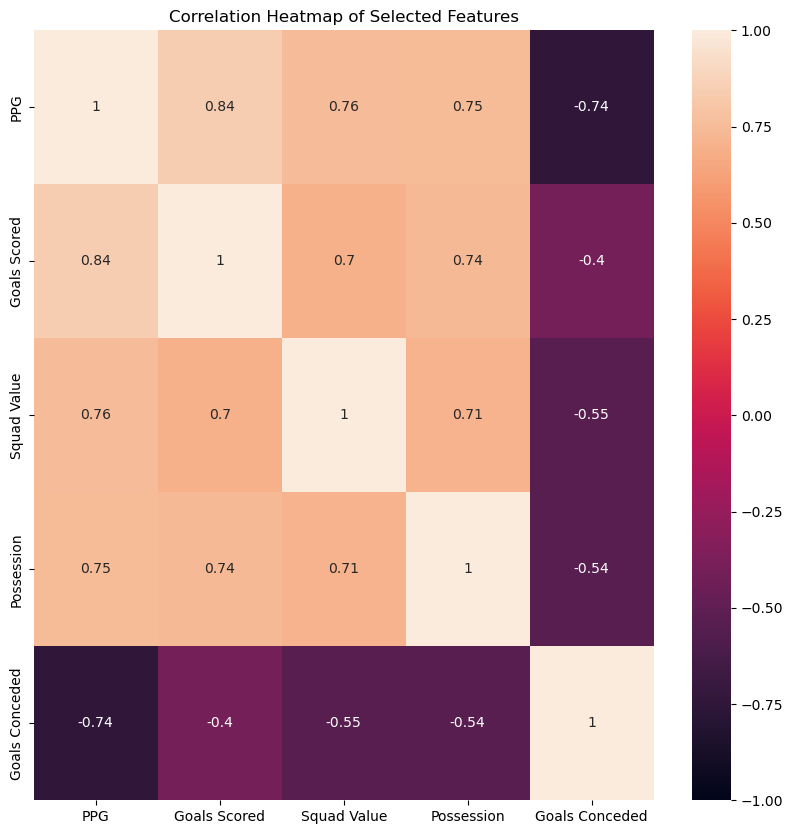

In [7]:
plt.figure(figsize=(10, 10))

RENAME_DICT = {
    "points_per90": "PPG", "goals_per90": "Goals Scored", "squad_value": "Squad Value",
    "possession": "Possession", "gk_goals_against_per90": "Goals Conceded",
}

heatmap_df = numeric_df[RENAME_DICT.keys()].rename(columns=RENAME_DICT).corr()

sns.heatmap(heatmap_df, vmin=-1, vmax=1, annot=True)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

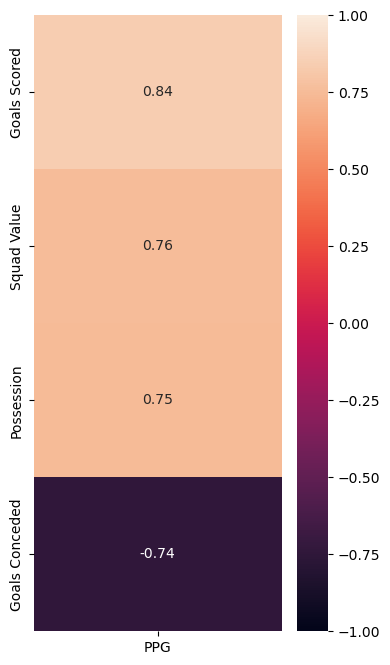

In [8]:
plt.figure(figsize=(4, 8))

heatmap_1_df = (pd.DataFrame(
    corr_matrix["points_per90"]
    .filter(items=[k for k in RENAME_DICT.keys() if k != "points_per90"])
    .sort_values(ascending=False)
).rename(index=RENAME_DICT, columns=RENAME_DICT))

sns.heatmap(heatmap_1_df, vmin=-1, vmax=1, annot=True)
plt.show()

### 1. Goals Scored & Conceded
#### Which is more important in winning games: attack or defence?
<i>Note: the following data has been averaged over the past 5 years (2018-23)</i>

In [9]:
# Comparing correlation to PPG: attack seems more strongly related to points per game
# goals_per90                              0.839428
# gk_goals_against_per90                  -0.745066

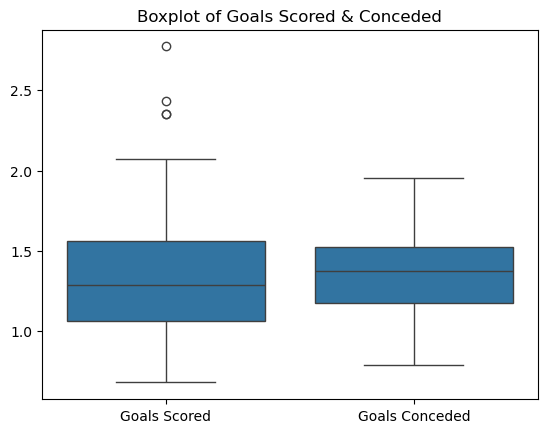


Outliers:


,squad,goals_per90,gk_goals_against_per90,gd_per90,country
0,Bayern Munich,2.7725,1.110294,1.6625,GER
1,Manchester City,2.4350,0.828947,1.6075,ENG
2,PSG,2.3550,0.906433,1.4475,FRA
3,Dortmund,2.3525,1.345588,1.0075,GER



Overview:


,goals_per90,gk_goals_against_per90,gd_per90
count,110.000000,110.000000,110.000000
mean,1.351288,1.363063,-0.011682
std,0.377594,0.255239,0.546968
min,0.680000,0.789474,-0.900000
25%,1.060625,1.174342,-0.390000
50%,1.285000,1.375000,-0.162500
75%,1.563125,1.524906,0.376042
max,2.772500,1.955882,1.662500



Interesting to note that while the mean is about the same, the spread of goals conceded is smaller than that of goals scored. Does this mean scoring is what separates the better sides from the worse ones?


In [10]:
atk_vs_def_df = pd.merge(
    (
        teams_agg_df[["squad", "goals_per90", "gk_goals_against_per90","gd_per90"]]
        .groupby("squad")
        .mean()
        .reset_index()
    ), teams_agg_df[["squad", "country"]].copy(),
    how="left",
    on="squad",
).drop_duplicates().reset_index(drop=True)

# Boxplot (melt to reshape dataframe and plot both variables on the same graph)
sns.boxplot(x="variable", y="value", data=pd.melt(
    atk_vs_def_df[["goals_per90", "gk_goals_against_per90"]].rename(columns=RENAME_DICT)
))

plt.xlabel('')
plt.ylabel('')
plt.title('Boxplot of Goals Scored & Conceded')
plt.show()
        
get_outliers(atk_vs_def_df, 'goals_per90')
print(
    "\nInteresting to note that while the mean is about the same, the spread of goals conceded is smaller than that of",
    "goals scored. Does this mean scoring is what separates the better sides from the worse ones?"
)

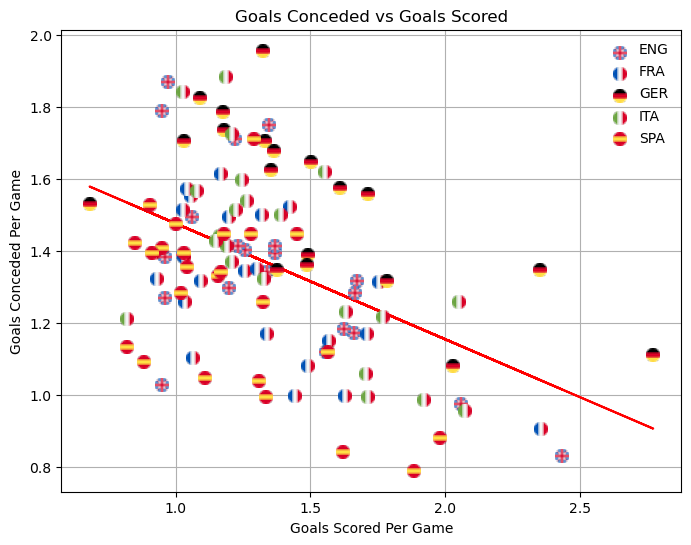

Highest- to lowest-scoring leagues:


,country,goals_per90,gk_goals_against_per90,gd_per90
1,GER,1.507500,1.540506,-0.033377
2,ITA,1.404962,1.393740,0.011250
3,ENG,1.358220,1.355263,0.002803
4,FRA,1.310833,1.305139,0.005870
5,SPA,1.210833,1.257127,-0.045625


Note: Slight differences in goals scored and conceded is due to data for newly promoted teams being pulled from the previous year.


In [11]:
def plot_atk_def_graph():
    plt.xlabel('Goals Scored Per Game')
    plt.ylabel('Goals Conceded Per Game')
    plt.title('Goals Conceded vs Goals Scored')
    plt.grid(True)
    plot_regression_line(atk_vs_def_df, 'goals_per90', 'gk_goals_against_per90')
    plt.show()

# Dictionary to map categories to images
country_icons = {
    country: get_country_icon(country) for country in list(atk_vs_def_df["country"].sort_values().unique())
}

plt.figure(figsize=(8, 6))

for category, group in atk_vs_def_df.groupby('country'):
    plt.scatter(
        x=group['goals_per90'],
        y=group['gk_goals_against_per90'],
        label=category,
        s=0
    )

#     Set custom markers for country
    for x, y in zip(group['goals_per90'], group['gk_goals_against_per90']):
        imagebox = OffsetImage(country_icons[category])
        plt.gca().add_artist(AnnotationBbox(imagebox, (x, y), frameon=False, pad=0))

plt.legend(framealpha=0, labelspacing=0.6)

# Add icons to each label in legend
for y, image in zip(np.arange(1.95, 1.6, -0.06), country_icons.values()):
    imagebox = OffsetImage(image)
    plt.gca().add_artist(AnnotationBbox(imagebox, (2.65, y), frameon=False, pad=0))

plot_atk_def_graph()

# Rank by country
atk_vs_def_country_df = (
    atk_vs_def_df.drop(columns=['squad']).groupby(by="country")
    .mean()
    .sort_values(by='goals_per90', ascending=False)
    .reset_index()
)
atk_vs_def_country_df.index += 1
print("Highest- to lowest-scoring leagues:")
display(atk_vs_def_country_df)
print(
    "Note: Slight differences in goals scored and conceded is due to data for",
    "newly promoted teams being pulled from the previous year."
)

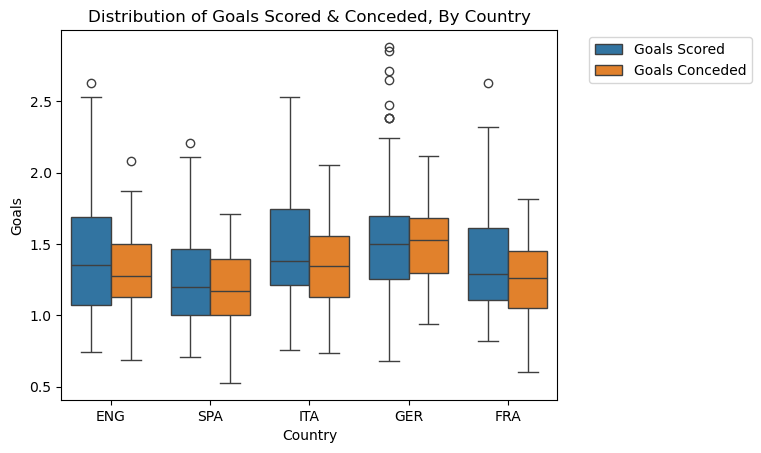

Germany has the most outliers for goals scored but not many for goals conceded: a few teams could be consistently scoring against multiple (weaker) clubs


In [12]:
country_goals_df = teams_agg_df[["country", "goals_per90", "gk_goals_against_per90"]].rename(columns=RENAME_DICT)
country_goals_df = pd.melt(
    country_goals_df, id_vars=['country'], value_vars=['Goals Scored', 'Goals Conceded'],
    var_name='Country', value_name='Goals',
)
sns.boxplot(x='country', y='Goals', hue='Country', data=country_goals_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Country')
plt.title("Distribution of Goals Scored & Conceded, By Country")
plt.show()

print("Germany has the most outliers for goals scored but not many for goals conceded:",
      "a few teams could be consistently scoring against multiple (weaker) clubs")

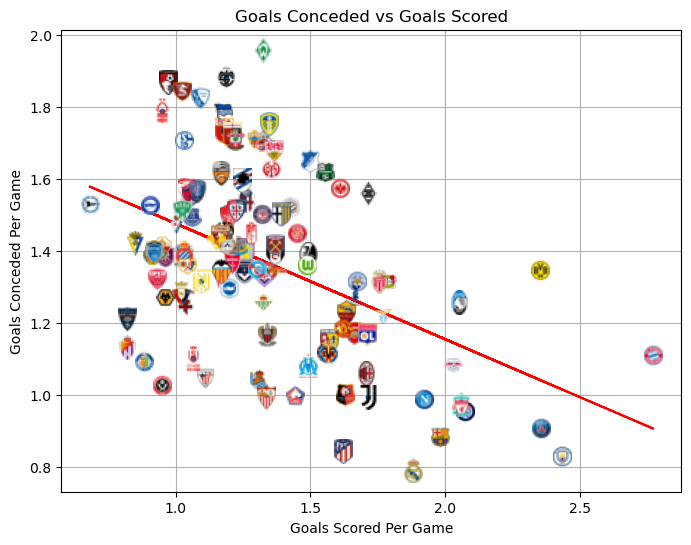

No strong correlation between goals_per90 and gk_goals_against_per90 (corr = -0.40)


In [13]:
plt.figure(figsize=(8, 6))

plt.scatter(
    x=atk_vs_def_df['goals_per90'],
    y=atk_vs_def_df['gk_goals_against_per90'],
    label=category,
    s=10
)

set_club_markers(atk_vs_def_df, 'goals_per90', 'gk_goals_against_per90')
plot_atk_def_graph()

_ = get_indiv_correlation(teams_agg_df, 'goals_per90', 'gk_goals_against_per90')

Most goals scored


,squad,goals_per90,gk_goals_against_per90,gd_per90,country
1,Bayern Munich,2.7725,1.110294,1.6625,GER
2,Manchester City,2.4350,0.828947,1.6075,ENG
3,PSG,2.3550,0.906433,1.4475,FRA
4,Dortmund,2.3525,1.345588,1.0075,GER
5,Inter,2.0725,0.953947,1.1175,ITA


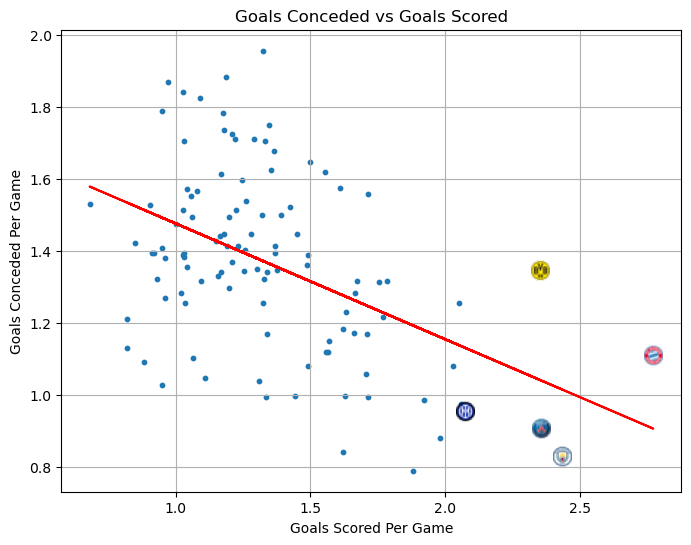

In [14]:
# Most goals scored
print("Most goals scored")
top_5_atk_df = atk_vs_def_df.sort_values(by="goals_per90", ascending=False).head().reset_index(drop=True)
top_5_atk_df.index += 1
display(top_5_atk_df)

plt.figure(figsize=(8, 6))

plt.scatter(
    x=atk_vs_def_df['goals_per90'],
    y=atk_vs_def_df['gk_goals_against_per90'],
    label=category,
    s=10
)

#     Set custom markers for top 5 clubs
set_club_markers(top_5_atk_df, 'goals_per90', 'gk_goals_against_per90')
plot_atk_def_graph()

Fewest goals conceded


,squad,goals_per90,gk_goals_against_per90,gd_per90,country
1,Real Madrid,1.8825,0.789474,1.0900,SPA
2,Manchester City,2.4350,0.828947,1.6075,ENG
3,Atl. Madrid,1.6200,0.842105,0.7775,SPA
4,Barcelona,1.9825,0.881579,1.1000,SPA
5,PSG,2.3550,0.906433,1.4475,FRA


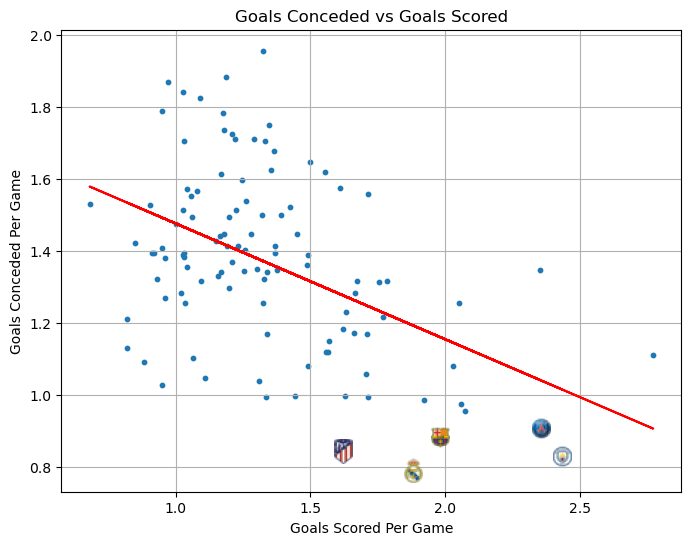

In [15]:
# Fewest goals conceded
print("Fewest goals conceded")
top_5_def_df = atk_vs_def_df.sort_values(by="gk_goals_against_per90").head().reset_index(drop=True)
top_5_def_df.index += 1
display(top_5_def_df)

plt.figure(figsize=(8, 6))

plt.scatter(
    x=atk_vs_def_df['goals_per90'],
    y=atk_vs_def_df['gk_goals_against_per90'],
    label=category,
    s=10
)

#     Set custom markers for top 5 clubs
set_club_markers(top_5_def_df, 'goals_per90', 'gk_goals_against_per90')
plot_atk_def_graph()

Best goal difference


,squad,goals_per90,gk_goals_against_per90,gd_per90,country
1,Bayern Munich,2.7725,1.110294,1.6625,GER
2,Manchester City,2.4350,0.828947,1.6075,ENG
3,PSG,2.3550,0.906433,1.4475,FRA
4,Inter,2.0725,0.953947,1.1175,ITA
5,Barcelona,1.9825,0.881579,1.1000,SPA


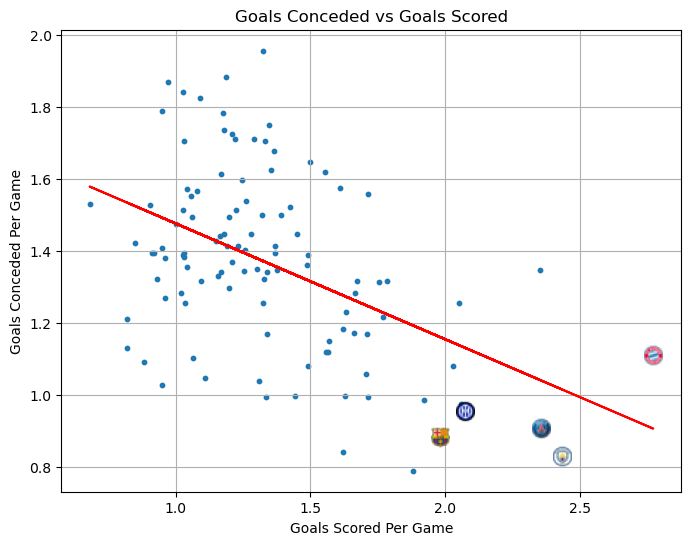

In [16]:
# Best goal difference
print("Best goal difference")
top_5_gd_df = atk_vs_def_df.sort_values(by="gd_per90", ascending=False).head().reset_index(drop=True)
top_5_gd_df.index += 1
display(top_5_gd_df)

plt.figure(figsize=(8, 6))

plt.scatter(
    x=atk_vs_def_df['goals_per90'],
    y=atk_vs_def_df['gk_goals_against_per90'],
    label=category,
    s=10
)

#     Set custom markers for top 5 clubs
set_club_markers(top_5_gd_df, 'goals_per90', 'gk_goals_against_per90')

plot_atk_def_graph()

/tmp/ipykernel_110481/2053347348.py:8: FutureWarning: The provided callable <function mean at 0x7f58140f6290> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = teams_agg_df[[*year_cols, col]].groupby(year_cols).agg(agg_func).reset_index()


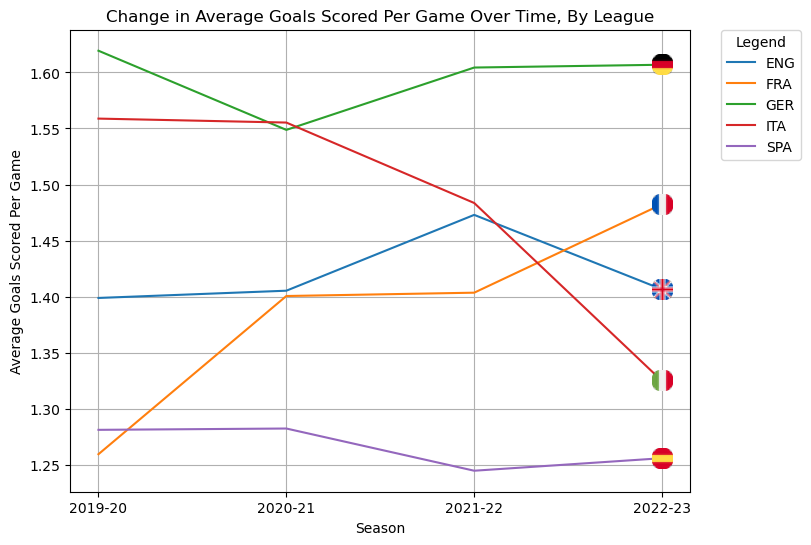

In [17]:
plot_country_line_graph("goals_per90")
    
plt.title("Change in Average Goals Scored Per Game Over Time, By League")
plt.xlabel("Season")
plt.ylabel("Average Goals Scored Per Game")
plt.show()

/tmp/ipykernel_110481/2053347348.py:8: FutureWarning: The provided callable <function mean at 0x7f58140f6290> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = teams_agg_df[[*year_cols, col]].groupby(year_cols).agg(agg_func).reset_index()


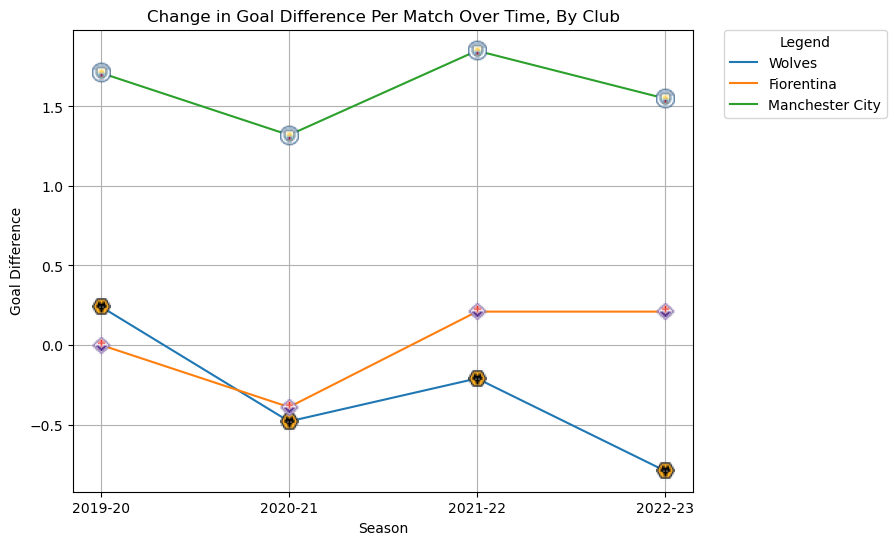

In [18]:
plot_club_line_graph("gd_per90")
    
plt.title("Change in Goal Difference Per Match Over Time, By Club")
plt.xlabel("Season")
plt.ylabel("Goal Difference")
plt.show()

### 2. Squad Value
#### Can money buy wins?
<i>Note: the following data has been averaged over the past 5 years (2018-23)</i>

In [19]:
# Correlation to PPG: strong positive correlation between squad value and points per game
# squad_value_avg                          0.768828

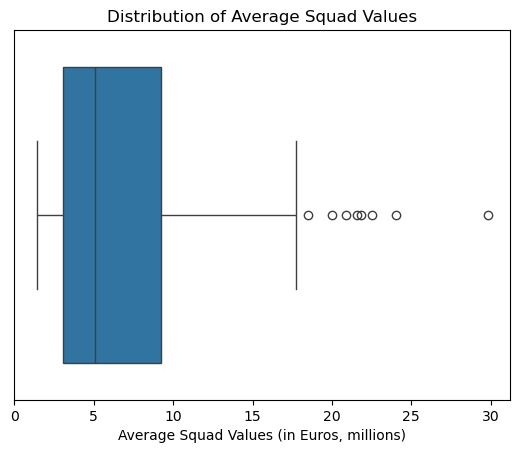


Outliers:


,squad,squad_value_avg,points_per90,country
0,Manchester City,29.8225,2.296053,ENG
1,Real Madrid,24.0075,2.203947,SPA
2,PSG,22.5125,2.294103,FRA
3,Bayern Munich,21.8600,2.264706,GER
4,Chelsea,21.5825,1.651316,ENG
5,Barcelona,20.9075,2.118421,SPA
6,Liverpool,20.0050,2.151316,ENG
7,Tottenham,18.4950,1.657895,ENG



Overview:


,squad_value_avg,points_per90
count,110.000000,110.000000
mean,7.307485,1.401478
std,5.952208,0.348186
min,1.420000,0.947368
25%,3.067500,1.151961
50%,5.087917,1.289474
75%,9.238125,1.651316
max,29.822500,2.296053



Significant outliers. The average squad value of the 99th percentile is a whopping 26.92 standard deviations larger than that of the median, indicating that there is a group of extremely wealthy clubs even amongst the top two tiers.


In [20]:
money_df = pd.merge(
    (
        teams_agg_df[["squad", "squad_value_avg", "points_per90"]]
        .groupby("squad")
        .mean()
        .reset_index()
    ), teams_agg_df[["squad", "country"]].copy(),
        how="left",
        on="squad",
).drop_duplicates().reset_index(drop=True)
money_df["squad_value_avg"] = money_df["squad_value_avg"] / pow(10, 6)

# Boxplot (melt to reshape dataframe and plot both variables on the same graph)
sns.boxplot(data=money_df["squad_value_avg"], orient="h")

plt.xlabel('Average Squad Values (in Euros, millions)')
plt.ylabel('')
plt.yticks([])
plt.title('Distribution of Average Squad Values')
plt.show()

money_outliers_df = get_outliers(money_df, "squad_value_avg")

print(
    "\nSignificant outliers. The average squad value of the 99th percentile",
    f"is a whopping {get_upper_deviation(money_df, 'squad_value_avg')} standard deviations",
    "larger than that of the median, indicating that there is a group of extremely wealthy",
    "clubs even amongst the top two tiers."
)

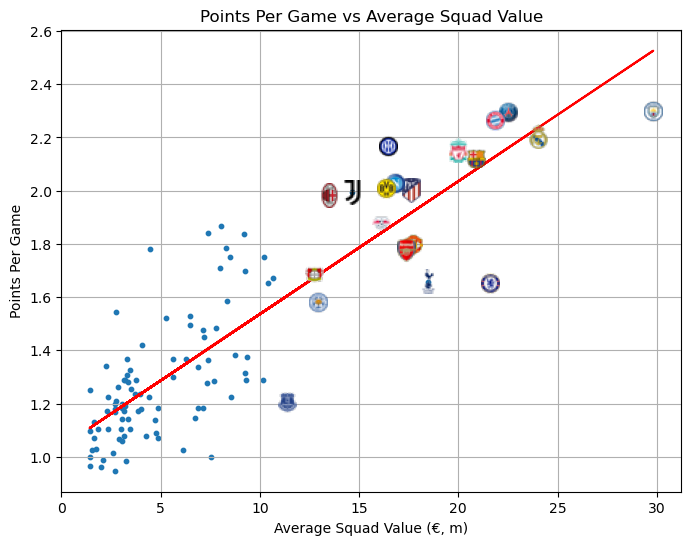

Strong correlation between squad_value_avg and points_per90 (corr = 0.77)


In [21]:
def plot_money_graph():
    plt.xlabel('Average Squad Value (€, m)')
    plt.ylabel('Points Per Game')
    plt.title('Points Per Game vs Average Squad Value')
    plt.grid(True)
    plt.show()

plt.figure(figsize=(8, 6))

plt.scatter(
    x=money_df['squad_value_avg'],
    y=money_df['points_per90'],
    label=money_df["squad"],
    s=10
)

plot_regression_line(money_df, 'squad_value_avg', 'points_per90')

#     Set custom markers for top 20 clubs with highest average squad value
money_top_20_df = money_df.sort_values(by="squad_value_avg", ascending=False).reset_index(drop=True).head(20)
set_club_markers(money_top_20_df, 'squad_value_avg', 'points_per90')
plot_money_graph()

_ = get_indiv_correlation(teams_agg_df, 'squad_value_avg', 'points_per90')

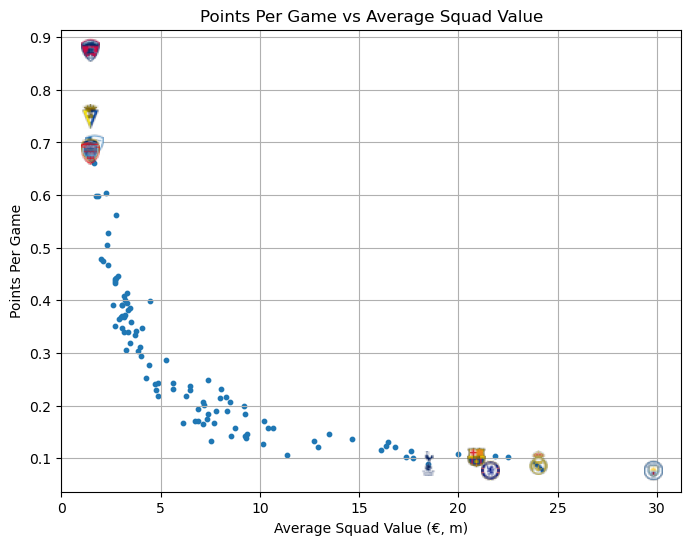


Top 5 "overperforming" teams:
(Teams that earn relatively high amount of points compared to their squad values)


,squad,squad_value_avg,points_per90,country,ppg_value_ratio
1,Clermont,1.430000,1.250000,FRA,0.874126
2,Cadiz CF,1.463333,1.096491,SPA,0.749311
3,Bochum,1.630000,1.132353,GER,0.694695
4,Troyes,1.460000,1.000000,FRA,0.684932
5,Nimes,1.420000,0.964286,FRA,0.679074



Top 5 "underperforming" teams:
(Teams that earn relatively low amount of points compared to their squad values. However, do note that teams can only take home so many points but can spend without a hard limit; some clubs with high PPG here are very successful)


,squad,squad_value_avg,points_per90,country,ppg_value_ratio
1,Chelsea,21.5825,1.651316,ENG,0.076512
2,Manchester City,29.8225,2.296053,ENG,0.076991
3,Tottenham,18.4950,1.657895,ENG,0.089640
4,Real Madrid,24.0075,2.203947,SPA,0.091802
5,Barcelona,20.9075,2.118421,SPA,0.101323


In [22]:
# Points per game to average squad value ratio
money_df["ppg_value_ratio"] = money_df["points_per90"] / money_df["squad_value_avg"]
undervalued_df = money_df.sort_values(by="ppg_value_ratio", ascending=False).reset_index(drop=True).head()
overvalued_df = money_df.sort_values(by="ppg_value_ratio").reset_index(drop=True).head()
undervalued_df.index += 1
overvalued_df.index += 1

plt.figure(figsize=(8, 6))

plt.scatter(
    x=money_df['squad_value_avg'],
    y=money_df['ppg_value_ratio'],
    label=money_df["squad"],
    s=10
)

#     Set custom markers for top 20 clubs with highest average squad value
set_club_markers(pd.concat([undervalued_df, overvalued_df]), 'squad_value_avg', 'ppg_value_ratio')
plot_money_graph()

print("\nTop 5 \"overperforming\" teams:")
print("(Teams that earn relatively high amount of points compared to their squad values)")
display(undervalued_df)

print("\nTop 5 \"underperforming\" teams:")
print(
    "(Teams that earn relatively low amount of points compared to their squad values. However, do note that teams",
    "can only take home so many points but can spend without a hard limit; some clubs with high PPG here are",
    "very successful)"
)
display(overvalued_df)

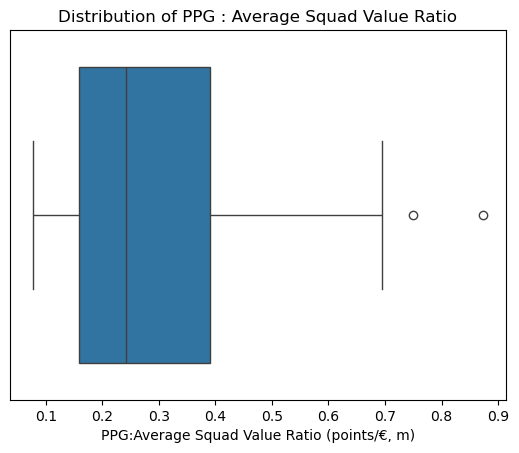


Outliers:


,squad,squad_value_avg,points_per90,country,ppg_value_ratio
0,Clermont,1.430000,1.250000,FRA,0.874126
1,Cadiz CF,1.463333,1.096491,SPA,0.749311



Overview:


,squad_value_avg,points_per90,ppg_value_ratio
count,110.000000,110.000000,110.000000
mean,7.307485,1.401478,0.294486
std,5.952208,0.348186,0.172004
min,1.420000,0.947368,0.076512
25%,3.067500,1.151961,0.158011
50%,5.087917,1.289474,0.242643
75%,9.238125,1.651316,0.390985
max,29.822500,2.296053,0.874126


In [23]:
# Boxplot (melt to reshape dataframe and plot both variables on the same graph)
sns.boxplot(data=money_df["ppg_value_ratio"], orient="h")

plt.xlabel('PPG:Average Squad Value Ratio (points/€, m)')
plt.ylabel('')
plt.yticks([])
plt.title('Distribution of PPG : Average Squad Value Ratio')
plt.show()

money_outliers_df = get_outliers(money_df, "ppg_value_ratio")

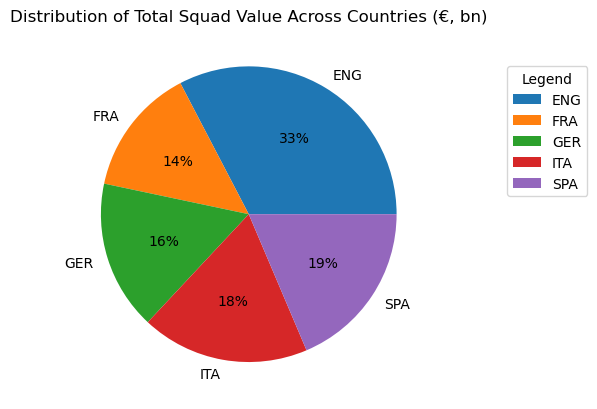

In [24]:
money_sum_by_country_df = teams_agg_df[["squad_value", "country"]].groupby("country").sum()
money_sum_by_country_df["squad_value"] = money_sum_by_country_df["squad_value"] / pow(10, 9)
money_sum_by_country_df.reset_index(inplace=True)

plt.pie(
    money_sum_by_country_df["squad_value"],
    labels=money_sum_by_country_df['country'].unique(),
    autopct='%.0f%%',
)
plt.title("Distribution of Total Squad Value Across Countries (€, bn)")
plt.legend(
    title="Legend",
    labels=money_sum_by_country_df['country'].unique(),
    bbox_to_anchor=(1.2, 0.9),
    loc='upper left',
    borderaxespad=0
)
plt.show()

/tmp/ipykernel_110481/2053347348.py:8: FutureWarning: The provided callable <function mean at 0x7f58140f6290> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = teams_agg_df[[*year_cols, col]].groupby(year_cols).agg(agg_func).reset_index()


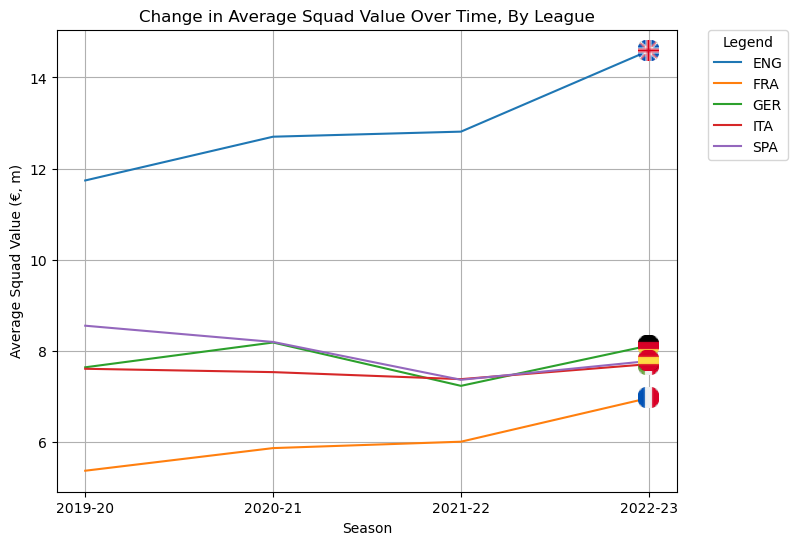

In [25]:
plot_country_line_graph("squad_value_avg", transform_col_func=lambda x: x/pow(10,6))
    
plt.title("Change in Average Squad Value Over Time, By League")
plt.xlabel("Season")
plt.ylabel("Average Squad Value (€, m)")
plt.show()

/tmp/ipykernel_110481/2053347348.py:8: FutureWarning: The provided callable <function mean at 0x7f58140f6290> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = teams_agg_df[[*year_cols, col]].groupby(year_cols).agg(agg_func).reset_index()


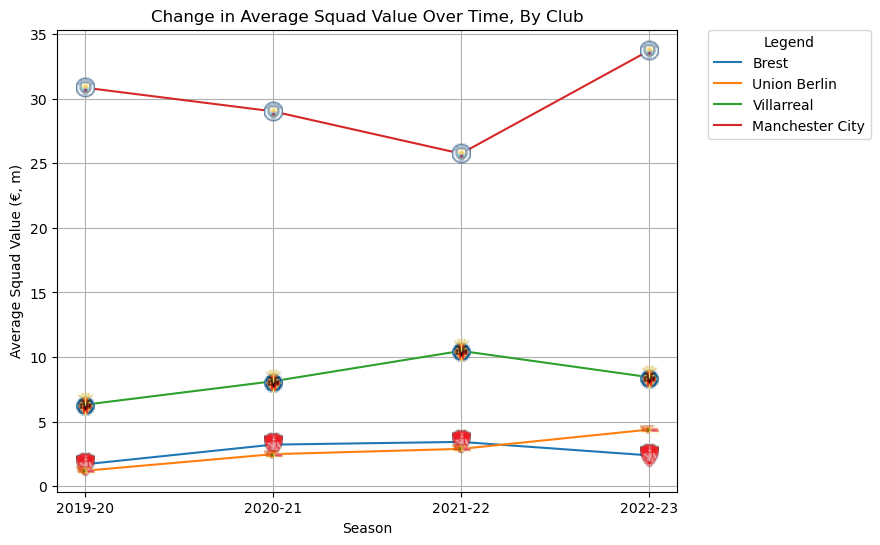

In [26]:
# Shows club at each quartile (based on last season's values)
plot_club_line_graph("squad_value_avg", transform_col_func=lambda x: x/pow(10,6))
    
plt.title("Change in Average Squad Value Over Time, By Club")
plt.xlabel("Season")
plt.ylabel("Average Squad Value (€, m)")
plt.show()

### 3. Possession
#### Possession vs Counter-Attack
<u>Strong positive correlaton between possession and PPG: more possession-heavy, dominant attacking sides seem to win more points</u>
<ol>
    <li>Correlation between possession & PPG: 0.748007</li>
    <li>
        Correlation between touches_live_ball_per90 & PPG: 0.757463
        <ul>
            <li>
                High possession naturally means more touches on the ball:
                <ul><li>Correlation between touches_live_ball_per90 & possession: 0.950651</li></ul>
            </li>
        </ul>
    </li>
    <li>
        Correlation between touches_att_3rd_per90 & PPG: 0.768357
        <ul>
            <li>
                More touches on the ball -> touches in the attacking third (strong positive correlation):
                <ul><li>Correlation between touches_att_3rd_per90 & possession: 0.853383</li></ul>
            </li>
            <li>
                More touches in the attacking third -> (strong positive correlation):
                <ul>
                    <li>Correlation between touches_att_3rd_per90 & sca_per90: 0.831509</li>
                    <li>Correlation between touches_att_3rd_per90 & sca_passes_live_per90: 0.863127</li>
                </ul>
            </li>
            <li>
                More shot-creating actions -> more goals (strong positive correlation):
                <ul>
                    <li>Correlation between sca_per90 & goals_per90: 0.788389</li>
                    <li>Correlation between sca_per90 & xg_per90: 0.861268</li>
                </ul>
            </li>
        </ul>
    </li>
    <li>
        Correlation between passes_total_distance_per90 & PPG: 0.753216
        <ul>
            <li>
                High possession naturally means more passes and thus more passing distance:
                <ul><li>Correlation between passes_total_distance_per90 & possession: 0.942511</li></ul>
            </li>
        </ul>
    </li>
</ol>
<i>To see how the correlation is derived, uncomment the relavant line of code in the next cell</i>

In [27]:
# Comments below are same as explanation above; uncomment .corr() code lines to view all correlations to that variable

# Strong positive correlaton to PPG: more possession-heavy, dominant attacking sides seem to win more points
# possession & PPG                         0.748007
numeric_df.corr()["possession"].sort_values()
# touches_live_ball_per90 & PPG            0.757463
    # High possession naturally means more touches on the ball
        # touches_live_ball_per90 & possession     0.950651
# touches_att_3rd_per90 & PPG              0.768357
    # More touches on the ball -> touches in the attacking third (strong positive correlation)
        # touches_att_3rd_per90 & possession       0.853383
    # More touches in the attacking third -> more shot-creating actions -> more goals (strong positive correlation)
        # teams_agg_df.corr()["touches_att_3rd_per90"].sort_values()
            # sca_per90 & touches_att_3rd_per90                 0.831509
            # sca_passes_live_per90 & touches_att_3rd_per90     0.863127
        # teams_agg_df.corr()["sca_per90"].sort_values()
            # goals_per90 & sca_per90                  0.788389
            # xg_per90 & sca_per90                     0.861268
# passes_total_distance_per90 & PPG         0.753216
    # High possession naturally means more passes and thus more passing distance
        # passes_total_distance_per90 & possession  0.942511

gk_pct_passes_launched                  -0.764267
clearances_per90                        -0.747496
gk_goal_kick_length_avg                 -0.639852
aerials_lost_per90                      -0.609742
gk_shots_on_target_against_per90        -0.546793
gk_psxg                                 -0.539470
gk_goals_against_per90                  -0.536605
goals_against_per90                     -0.536210
goals_against_away_per90                -0.501926
blocked_shots_per90                     -0.497051
aerials_won_per90                       -0.478762
tackles_def_3rd_per90                   -0.458523
goals_against_home_per90                -0.379040
blocks_per90                            -0.361970
interceptions_per90                     -0.329118
take_ons_tackled_pct                    -0.321513
passes_dead_per90                       -0.321182
average_shot_distance                   -0.320237
fouls_per90                             -0.313081
tackles_interceptions_per90             -0.291598


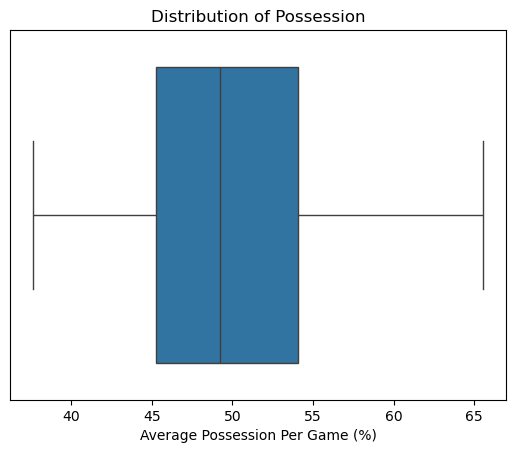


Overview:


,possession,points_per90
count,110.000000,110.000000
mean,49.795606,1.401478
std,5.813727,0.348186
min,37.600000,0.947368
25%,45.287500,1.151961
50%,49.200000,1.289474
75%,54.043750,1.651316
max,65.575000,2.296053



No outliers. However, the average squad value of the 99th percentile is a massive 65.34 standard deviations larger than that of the median, while the 1st percentile is 65.34 SDs below the median. This could be a reflection of vastly different playing styles by a few clubs.


In [28]:
possession_df = pd.merge(
    (
        teams_agg_df[["squad", "possession", "points_per90"]]
        .groupby("squad")
        .mean()
        .reset_index()
    ), teams_agg_df[["squad", "country"]].copy(),
        how="left",
        on="squad",
).drop_duplicates().reset_index(drop=True)

# Boxplot (melt to reshape dataframe and plot both variables on the same graph)
sns.boxplot(data=possession_df["possession"], orient="h")

plt.xlabel('Average Possession Per Game (%)')
plt.ylabel('')
plt.yticks([])
plt.title('Distribution of Possession')
plt.show()

possession_outliers_df = get_outliers(possession_df, "possession")

print(
    "\nNo outliers. However, the average squad value of the 99th percentile",
    f"is a massive {get_upper_deviation(possession_df, 'possession')} standard deviations",
    "larger than that of the median, while the 1st percentile is",
    f"{get_upper_deviation(possession_df, 'possession')} SDs below the median.",
    "This could be a reflection of vastly different playing styles by a few clubs."
)

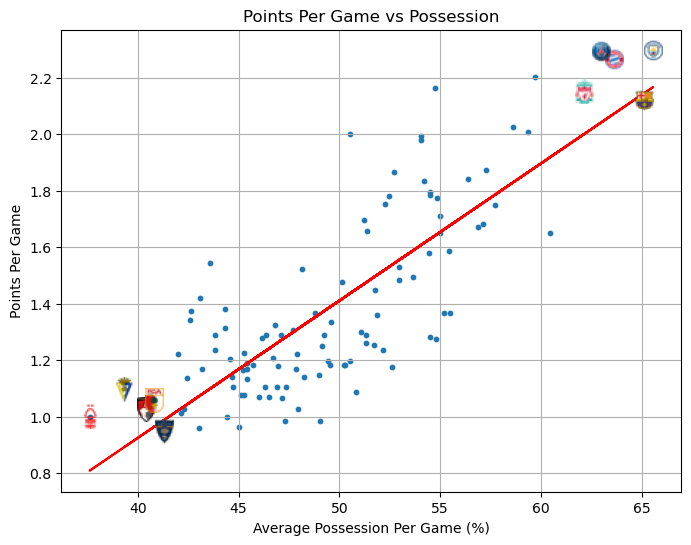


Top 5 posession-based teams:


,squad,possession,points_per90,country
1,Manchester City,65.575,2.296053,ENG
2,Barcelona,65.100,2.118421,SPA
3,Bayern Munich,63.625,2.264706,GER
4,PSG,63.000,2.294103,FRA
5,Liverpool,62.125,2.151316,ENG



Top 5 counter-attacking teams:


,squad,possession,points_per90,country
1,Nottingham,37.600000,1.000000,ENG
2,Cadiz CF,39.333333,1.096491,SPA
3,Bournemouth,40.400000,1.026316,ENG
4,Augsburg,40.800000,1.058824,GER
5,Lecce,41.300000,0.947368,ITA


Strong correlation between possession and points_per90 (corr = 0.81)


In [29]:
def plot_possession_graph():
    plt.xlabel('Average Possession Per Game (%)')
    plt.ylabel('Points Per Game')
    plt.title('Points Per Game vs Possession')
    plt.grid(True)
    plt.show()

plt.figure(figsize=(8, 6))

plt.scatter(
    x=possession_df['possession'],
    y=possession_df['points_per90'],
    label=possession_df["squad"],
    s=10
)

plot_regression_line(possession_df, 'possession', 'points_per90')

# Most and least posession-based teams
possession_top_5_df = possession_df.sort_values(by="possession", ascending=False).reset_index(drop=True).head()
park_bus_top_5_df = possession_df.sort_values(by="possession").reset_index(drop=True).head()
possession_top_5_df.index += 1
park_bus_top_5_df.index += 1

#     Set custom markers for extreme-cases
set_club_markers(pd.concat([possession_top_5_df, park_bus_top_5_df]), 'possession', 'points_per90')
plot_possession_graph()

print("\nTop 5 posession-based teams:")
display(possession_top_5_df)

print("\nTop 5 counter-attacking teams:")
display(park_bus_top_5_df)

_ = get_indiv_correlation(possession_df, 'possession', 'points_per90')

#### Other Correlations and Resulting Observations

In [30]:
def plot_jointplot(df, col1, col2, label, options={}):
    '''options is a dictionary that can contain the following attributes:
    figsize: A tuple
    cmap: defaults to coolwarm
    fig_specs: a dictionary with the following: title, xlabel, ylabel, label_fontsize
    '''
    
    if label not in df.columns:
        print(f"Column for label: {label} was not found in dataframe")
        return
    
    fig_specs = options.get('fig_specs', {})
    
    g = sns.jointplot(x=col1, y=col2, data=df, kind='scatter')
    
    params = options.get('params', {})
    params['cmap'] = params.get('cmap', 'coolwarm')
    scatter = g.ax_joint.scatter(df[col1], df[col2], c=df[label], **params)

    # color bar
    cbar = plt.colorbar(scatter, ax=g.ax_joint)
    cbar.set_label(label)
    
    plt.subplots_adjust(top=0.9)
    g.figure.suptitle(fig_specs.get('title', f'Reg Plot of {label} for {col1} and {col2}'), fontsize=fig_specs.get('title_fontsize', 16))
    g.set_axis_labels(fig_specs.get('xlabel', col1), fig_specs.get('ylabel', col2), fontsize=fig_specs.get('label_fontsize', 12))

    plt.show()

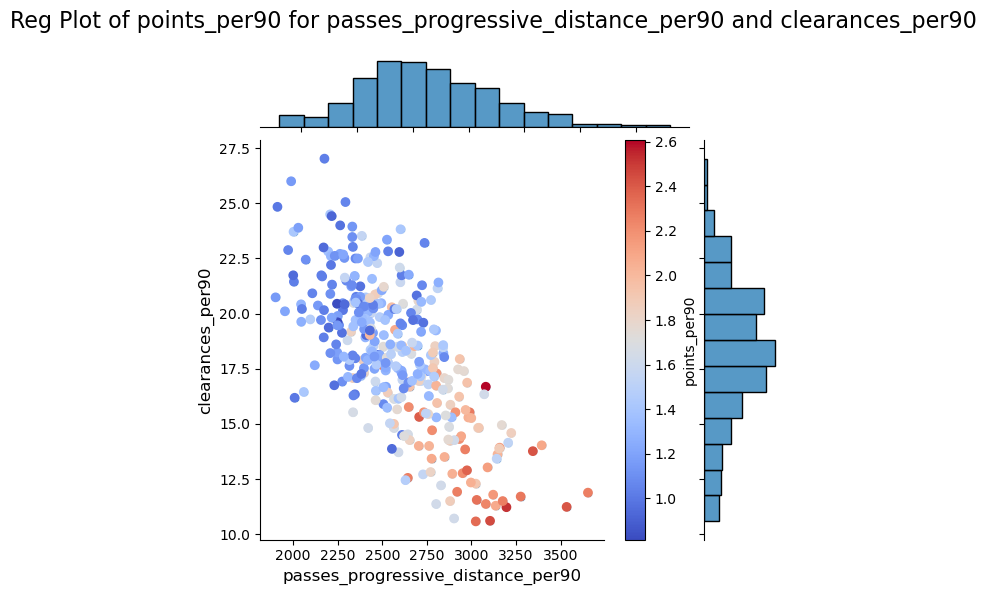

In [31]:
plot_jointplot(teams_agg_df, 'passes_progressive_distance_per90', 'clearances_per90', 'points_per90')

- Inverse correlation between Clearances and Progressive passes 
- Positive correlation between Progressive passes and Points
- Inverse correlation between Clearances and Points

### Finding Correlations and plotting a random jointplot

In [32]:
with open(AGG_COL_TO_CAT_DICT_PATH, 'rb') as file:
    AGG_COL_TO_CAT_DICT = json.load(file)

with open(BORUTA_FEATURES_PATH, 'rb') as file:
    BORUTA_FEATURES = json.load(file)

def check_columns(col1, col2):
    min_threshold = 0.6
    max_threshold = 1
    if f'team_{col1}' not in BORUTA_FEATURES and f'team_{col2}' not in BORUTA_FEATURES:
        return False

    if not min_threshold <= abs(corr_matrix.at['points_per90', col1]) <= max_threshold:
        return False

    if col1 == col2 or AGG_COL_TO_CAT_DICT[col1] == AGG_COL_TO_CAT_DICT[col2]:
        return False
    
    return True


corr_cols = []
for col1 in corr_matrix['points_per90'].index:
    # Check if the correlation between 'points_per90' and 'col1' is significant
    if check_columns(col1, 'points_per90'):
        # Now check this 'col1' against all other features
        for col2 in corr_matrix.index:
            if check_columns(col1, col2) and check_columns(col2, 'points_per90'):
                print(f"Correlation found between 'points_per90', '{col1}', and '{col2}")
                corr_cols.append((col1, col2, 'points_per90'))

if len(corr_cols) == 0:
    print("No Correlations found")

Correlation found between 'points_per90', 'squad_value', and 'assists_per90
Correlation found between 'points_per90', 'squad_value', and 'corner_kicks_per90
Correlation found between 'points_per90', 'assists_per90', and 'squad_value
Correlation found between 'points_per90', 'assists_per90', and 'corner_kicks_per90
Correlation found between 'points_per90', 'corner_kicks_per90', and 'squad_value
Correlation found between 'points_per90', 'corner_kicks_per90', and 'assists_per90


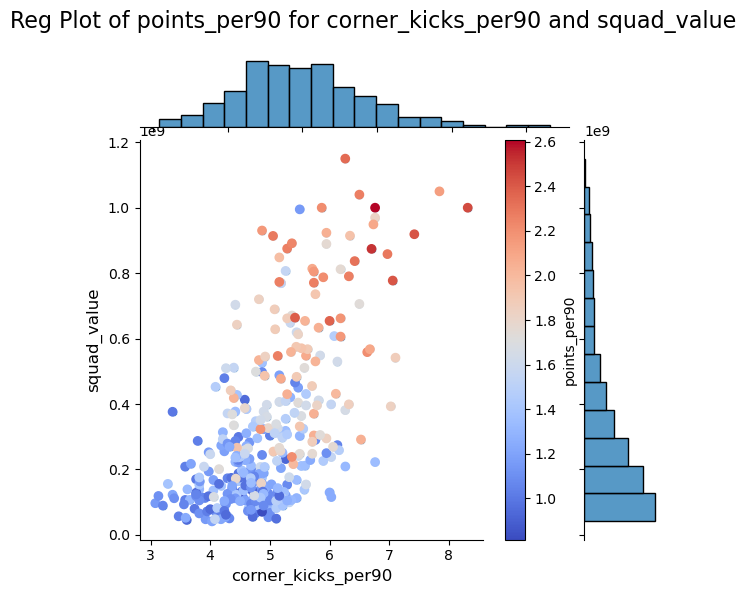

In [33]:
# SELECT A RANDOM COLUMN
import random
if len(corr_cols) > 0:
    idx = random.randint(0, len(corr_cols) - 1)
    # Select the element at the random index
    selected_column = corr_cols[idx]

    plot_jointplot(teams_agg_df, *selected_column)
else:
    print("No correlations found")

Correlation to PPG

In [34]:
# Having to clear more often means opponents are creating more chances more often
# Indicative of back-foot play? Is high-pressing/high-possession the way to go?
# clearances_per90                        -0.642397
# tackles_def_3rd_per90                   -0.457455
# blocked_shots_per90                     -0.405874

# Importance of aerial duels
# aerials_lost_per90                      -0.526721

# More likely to lose if goalkeeper plays long?
# Need more data to check if goalkeeper plays long == don't build from the back == less-possession-based
# gk_pct_passes_launched                  -0.557303

# Easier to score from inside the box
# touches_att_pen_area_per90               0.774190
# passes_into_final_third_per90            0.780436

# Dribbling is important too
# carries_per90                            0.711977
# carries_into_penalty_area_per90          0.704944
# carries_progressive_distance_per90       0.698366

# Importance of set pieces
# corner_kicks_per90                       0.619333

# Creating chances > finishing chances
# shots_on_target_per90                    0.774389
# goals_per_shot_on_target                 0.527539

# High press is not always better
# tackles_att_3rd                          0.444717
# tackles_att_3rd_per90                    0.471157

Cross-category correlation

In [35]:
# # Get correlation
teams_corr_df = get_correlation(numeric_df, list(numeric_df.columns))

# Filter out correlations between similar variables
teams_corr_df[
    teams_corr_df.apply(
        lambda row: in_different_category(row['col_1'], row['col_2']),
        axis=1
    )
].reset_index(drop=True)
teams_corr_df.sample(20).sort_index()

,col_1,col_2,corr
154,npxg_per90,touches_att_pen_area_per90,0.889387
638,assists_per90,touches_per90,0.766523
1080,points_per90,gk_psxg,0.683992
1170,goals_assists_per90,carries_distance_per90,0.664352
2117,touches_att_3rd_per90,take_ons_per90,0.454347
2837,points_away_per90,xg_assist_net_per90,0.348587
3087,average_shot_distance,carries_into_penalty_area_per90,0.319211
4539,passes_dead_per90,tackles_att_3rd_per90,0.194649
4759,passes_pct,crosses_into_penalty_area_per90,0.181131
4980,squad_size,challenges_per90,0.169894


In [36]:
# Note: the following correlation values are absolute (i.e. |corr|)
# as we are measuring strength of correlationship for now
# KIV: are a few outliers skewing the metrics?

# Strong correlation between passes and carries
# passes_live	carries_distance	0.889320
# passes_into_final_third	carries	0.883365
# passes_pct	carries	0.835825

# Strong correlation between progressive actions and: g/a, possession
# teams_corr_df[
#     (teams_corr_df['col_1'].str.contains("progressive", regex=True)) |
#     (teams_corr_df['col_2'].str.contains("progressive", regex=True))
# ]

# Strong correlation between possession and g/a
# teams_corr_df[
#     (
#         (teams_corr_df['col_1'].str.contains("possession", regex=True)) &
#         (teams_corr_df['col_2'].str.contains("x", regex=True))
#     ) | (
#         (teams_corr_df['col_1'].str.contains("x", regex=True)) &
#         (teams_corr_df['col_2'].str.contains("possession", regex=True))
#     )
# ]

# Looking at defensive metrics
# teams_corr_df[
#     (teams_corr_df['col_1'].isin(TEAM_COLUMNS_DICT_COMBINED["defence"])) |
#     (teams_corr_df['col_2'].isin(TEAM_COLUMNS_DICT_COMBINED["defence"]))
# ]

# High press =/= high possession
# teams_corr_df[
#     (teams_corr_df['col_1'].str.contains("tackles_att_3rd", regex=True)) |
#     (teams_corr_df['col_2'].str.contains("tackles_att_3rd", regex=True))
# ]

# Q: Is technical and physical ability mutually exclusive?
# A: Probably not? More direct/long-ball teams may lose more aerial duels and
# have lower overall pass accuracy (because of long balls)
# passes_pct	aerials_lost	0.756948
# passes_pct_short	aerials_won	0.625621

### Using past data to predict future results
Recall from data_processing: we only have last season's performance data to predict this season's results, thus we need to see if the hypothesis we drew from using the same season's performance data for that same seaons's results also holds true for the correlation between previous season's performance and this season's results

From the table below:
- <u><i>Squad value</i>: weaker (but only relatively stronger than the other indicators); if managers and playing staff do not change significantly, results are unlikely to be affected</u>
    - squad_value_avg&emsp;&emsp;0.669588
    - squad_value&emsp;&emsp;0.659756
- <u><i>Possession</i>: much weaker; possibly due to the phenomenon where relegation-threatened teams bring in managers that play "safer", counter-attacking football</u>
    - possession&emsp;&emsp;0.448408

In [37]:
# Recall from data_processing: previous season's performance metrics to predict this season's results
# (i.e. `season_start_year == 2019` comprises of results from 2019-20 and performance metrics from 2018-19)
#
# Performance metrics: 'points', 'goals_for', 'goals_against', 'points_home', 'goals_for_home', 'goals_against_home',
#                      'points_away', 'goals_for_away', 'goals_against_away'
prev_season_df = pd.read_csv('./data/exploratory_analysis/eda_prev_season.csv')

In [38]:
numeric_prev_df = prev_season_df.select_dtypes(include=[np.number])
corr_matrix_prev = numeric_prev_df.corr()
corr_matrix_prev['points_per90'].sort_values(ascending=False)

points_per90                             1.000000
points_away_per90                        0.918633
points_home_per90                        0.916578
goals_for_per90                          0.880306
goals_for_home_per90                     0.822381
goals_for_away_per90                     0.808940
squad_value_avg                          0.671869
squad_value                              0.661994
touches_mid_3rd_per90                    0.575424
passes_live_per90                        0.573221
touches_per90                            0.560008
touches_live_ball_per90                  0.559862
passes_total_distance_per90              0.536439
touches_att_3rd_per90                    0.531549
passes_into_final_third_per90            0.528342
passes_pct_long                          0.522584
carries_into_final_third_per90           0.521516
passes_pct                               0.514787
gca_per90                                0.513646
carries_into_penalty_area_per90          0.512564
